# Camera Calibrations 10/1/21

This notebook is based on the camera calibrations template notebook.

This notebook analyzes a series of pictures and from them derives the photons/count rate of the camera for the given mode.

It can do either averaging all pixels over a large picture (where we worry about spatial inhomogeneity) or averaging a single location over many pictures.

## Imports and Defines

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py as h5
from scipy.optimize import curve_fit
from scipy.stats import linregress
%matplotlib inline
from matplotlib import rcParams
from tqdm import tqdm
import time

In [2]:
# current date, for retrieving data from proper location.
year = "2024"
month = "May"
day = "15"

In [3]:
import sys
sys.path.append("../../..")
from Analysis_Python_Files.fitters.Gaussian import dip, double_dip, bump, bump2, bump3, bump2r, gaussian, bump3_Sym, gaussian_2d
from Analysis_Python_Files.fitters.Sinc_Squared import sinc_sq3_Sym, sinc_sq
from Analysis_Python_Files.fitters import decaying_cos, exponential_decay_fixed_limit as decay, linear, LargeBeamMotExpansion, n1State
import Analysis_Python_Files.PictureWindow as pw
import Analysis_Python_Files.ExpFile as exp
exp.setPath(day, month, year)
import Analysis_Python_Files.PlotlyPlotters as pp
import Analysis_Python_Files.MatplotlibPlotters as mp
import Analysis_Python_Files.MainAnalysis as ma
import Analysis_Python_Files.AnalysisHelpers as ah
import Analysis_Python_Files.Miscellaneous as misc
import Analysis_Python_Files.PopulationAnalysis as pa
import Analysis_Python_Files.MarksConstants as mc
import Analysis_Python_Files.fitters as fitters
import Analysis_Python_Files.LoadingFunctions as lf
import Analysis_Python_Files.FreeSpaceImaging as fsi
import Analysis_Python_Files.TransferAnalysis as ta
import Analysis_Python_Files.LightShiftCalculations as lsc
import Analysis_Python_Files.CalibrationAnalysis as ca
# It's important to explicitly import calPoint here or else pickling doesn't work.
from Analysis_Python_Files.CalibrationAnalysis import calPoint 
from Analysis_Python_Files.TransferAnalysisOptions import TransferAnalysisOptions as ao
import Analysis_Python_Files.ThresholdOptions as to
import Analysis_Python_Files.TransferAnalysisOptions as tao
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
from Analysis_Python_Files.AnalysisHelpers import fitManyGaussianImage

In [4]:
rcParams['font.family'] = 'sans-serif';
rcParams['axes.linewidth'] = 1.5;
rcParams['axes.titlesize'] = 20
rcParams['axes.labelsize'] = 20
rcParams['xtick.labelsize'] = 15
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['ytick.labelsize'] = 15
rcParams['lines.linewidth'] = 2.5
rcParams['lines.color'] = 'k'
plot_width = 8;
plot_height = 5;
# plt.grid(False);

## Analyze Single Picture

In [2]:
def analyzeSinglePicture(cal_type, firstRun, lastRun, printProgress=True):
    """
    This function is for calculating averages of pictures, finding the average pixel signal and variance
    of all pixel signals on the pictures.
    
    :return: This function returns the counts/photon

    """
    allPictures = []
    allAverages = []
    allVariances = []
    dataRepositoryPath = "\\\\REGALB232EXP\\Local_Data_Repository\\2021\\andor_cal\\"
    for runInc in range(firstRun, lastRun + 1, 1):
        dataPath = dataRepositoryPath + cal_type + "\\data_" + str(runInc) + ".h5"
        with h5.File(dataPath, "r") as hdf:
            andor = hdf.get('Andor')
            andor_items = list(andor.items())
            allPictures = np.array(andor.get('Pictures'))
        allPictures = [item for sublist in list(allPictures[0]) for item in sublist];
        allAverages.append(np.mean(allPictures))
        allVariances.append(np.std(allPictures)**2)
        totalAverage = np.mean(allAverages)
        totalVariance = np.mean(allVariances)
        photonCount = totalAverage/totalVariance
    return 'counts/photon =', photonCount
    

In [3]:
analyzeSinglePicture("conv_gain",3,7)

('counts/photon =', 0.4955704939296838)

# Analyze Single Location

In [10]:
def line(x, a, b):
    return a * x + b

def analyzeSingleLocation(cal_type, firstRun, lastRun, location, printStatus=False, plot=False):
    """
    Analyzes a single location, averaging over many pictures.
    The function assumes that there is a data file for all runs in between firstrun and lastrun.
    
    :return: The function returns the fit object (i.e. an array of [a, b] for the linear fit y = a x + b) 
    and the covariance of said fit.
    """
    allAverages = []
    allVariances = []
    dataRepositoryPath = "\\\\REGALB232EXP\\Local_Data_Repository\\2021\\andor_cal\\"

    for runInc in range(firstRun, lastRun + 1, 1):
        allPoints = []
        dataPath = dataRepositoryPath + cal_type + "\\data_" + str(runInc) + ".h5"
        with h5.File(dataPath, "r") as hdf:
            andor = hdf.get('Andor')
            andor_items = list(andor.items())
            dataFile = np.array(andor.get('Pictures'))   
        for repInc in range(0, 2000):
            allPoints.append(dataFile[repInc][location[0]][location[1]]) 
            # print(allPoints)
        allAverages.append(np.mean(allPoints))
        allVariances.append(np.std(allPoints)**2)
        
    param, cov = curve_fit(line, allVariances, allAverages, [1, 0]) 
    return param, cov, param[0], allAverages, allVariances; 

### Load Conventional Gain Data

In [83]:
# initialize some arrays
conv_1x1Fits = []
conv_1x1Covs = []
conv_1x1PhotonPerCounts = []
conv_1x1Averages = []
conv_1x1Variances = []

# average over the four corners.
for location in [[0, 0],[-1, 0], [0, -1], [-1, -1]]:
#     print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("conv_gain", 3, 7, location, True)
    conv_1x1Fits = np.append(conv_1x1Fits, fit)
    conv_1x1Covs = np.append(conv_1x1Covs, cov)
    conv_1x1PhotonPerCounts = np.append(conv_1x1PhotonPerCounts, fit1) # generate list of slopes for each pixel as defined in location
    conv_1x1Averages = np.append(conv_1x1Averages, averages)
    conv_1x1Variances = np.append(conv_1x1Variances, variances)

In [84]:
conv_1x1PhotonPerADCount = np.mean(conv_1x1PhotonPerCounts) # average slopes
conv_1x1PhotonPerADstd = np.std(conv_1x1PhotonPerCounts)
print('counts/photon =', conv_1x1PhotonPerADCount)
print('std dev =', conv_1x1PhotonPerADstd)

counts/photon = 0.6367330158458274
std dev = 0.01303050551334851


r_value = 0.9985549912778052
slope =  0.6349928295292211


C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_1856/2825264123.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


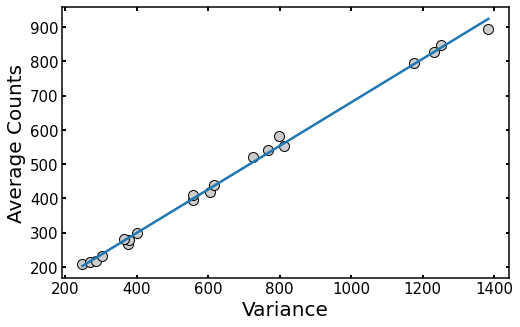

In [129]:
x = conv_1x1Variances
y = conv_1x1Averages
plt.scatter(x,y,s=100,c='0.8',edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='tab:blue');
m, b = np.polyfit(x, y, 1)
# plt.title('Andor - Conventional Gain',fontsize = title_font_size)
plt.xlabel('Variance')
plt.ylabel('Average Counts')
fig = plt.gcf();
fig.set_size_inches(plot_width, plot_height);
plt.grid(False)
ax = plt.subplot()
ax.tick_params(direction='in')
ax.tick_params(bottom=True, top=True, left=True, right=True)


# plt.savefig('conv_gain.png',dpi=1000)
# slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('r_value =',r_value)
print('slope = ',slope)

In [39]:
# initialize some arrays
EM_100_1x1Fits = []
EM_100_1x1Covs = []
EM_100_1x1PhotonPerCounts = []
EM_100_1x1Averages = []
EM_100_1x1Variances = []

# average over the four corners.
for location in [[0, 0],[-1, 0], [0, -1], [-1, -1]]:
#     print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("EM_100", 3, 7, location, True)
    EM_100_1x1Fits = np.append(EM_100_1x1Fits, fit)
    EM_100_1x1Covs = np.append(EM_100_1x1Covs, cov)
    EM_100_1x1PhotonPerCounts = np.append(EM_100_1x1PhotonPerCounts, fit1) # generate list of slopes for each pixel as defined in location
    EM_100_1x1Averages = np.append(EM_100_1x1Averages, averages)
    EM_100_1x1Variances = np.append(EM_100_1x1Variances, variances)

In [120]:
EM_100_1x1PhotonPerADCount = np.mean(EM_100_1x1PhotonPerCounts)*2 # average slopes
EM_100_1x1PhotonPerADstd = np.std(EM_100_1x1PhotonPerCounts)*2
EM_100_1x1PhotonPerADCount_scaled = np.mean(EM_100_1x1PhotonPerCounts)*2*100 
print('counts/photon =', EM_100_1x1PhotonPerADCount)
print('std dev =', EM_100_1x1PhotonPerADstd*2)
print('counts/photon scaled =', EM_100_1x1PhotonPerADCount_scaled)

counts/photon = 0.04064535581518338
std dev = 0.003826935144717846
counts/photon scaled = 4.064535581518338


C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_1856/2166503226.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


slope =  0.020154439195143807


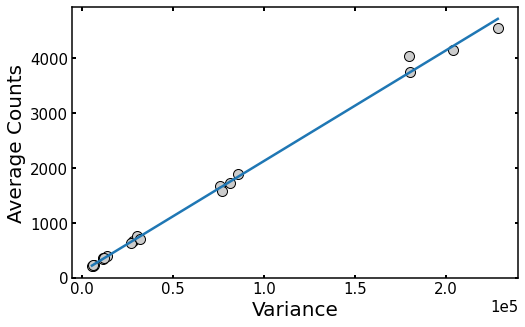

In [133]:
x = EM_100_1x1Variances
y = EM_100_1x1Averages
plt.scatter(x,y,s=100,c='0.8',edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='tab:blue');
m, b = np.polyfit(x, y, 1)
# plt.title('Andor - Conventional Gain',fontsize = title_font_size)
plt.xlabel('Variance')
plt.ylabel('Average Counts')
fig = plt.gcf();
fig.set_size_inches(plot_width, plot_height);
plt.grid(False)
ax = plt.subplot()
ax.tick_params(direction='in')
ax.tick_params(bottom=True, top=True, left=True, right=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('EM100_gain.png',dpi=1000)
print('slope = ',m)

In [44]:
# initialize some arrays
EM_300_1x1Fits = []
EM_300_1x1Covs = []
EM_300_1x1PhotonPerCounts = []
EM_300_1x1Averages = []
EM_300_1x1Variances = []

# average over the four corners.
for location in [[0, 0],[-1, 0], [0, -1], [-1, -1]]:
#     print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("EM_300", 9, 13, location, True)
    EM_300_1x1Fits = np.append(EM_300_1x1Fits, fit)
    EM_300_1x1Covs = np.append(EM_300_1x1Covs, cov)
    EM_300_1x1PhotonPerCounts = np.append(EM_300_1x1PhotonPerCounts, fit1) # generate list of slopes for each pixel as defined in location
    EM_300_1x1Averages = np.append(EM_300_1x1Averages, averages)
    EM_300_1x1Variances = np.append(EM_300_1x1Variances, variances)

In [137]:
EM_300_1x1PhotonPerADCount = np.mean(EM_300_1x1PhotonPerCounts)*2 # average slopes
EM_300_1x1PhotonPerADstd = np.std(EM_300_1x1PhotonPerCounts)*2
EM_300_1x1PhotonPerADCount_scaled = np.mean(EM_300_1x1PhotonPerCounts)*2*300
print('counts/photon =', EM_300_1x1PhotonPerADCount)
print('std dev =', EM_300_1x1PhotonPerADstd)
print('counts/photon Scaled =', EM_300_1x1PhotonPerADCount_scaled)

counts/photon = 0.013629068269407966
std dev = 0.0002638596372574341
counts/photon Scaled = 4.088720480822389


C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_1856/2716981000.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


slope =  0.006808344261676491


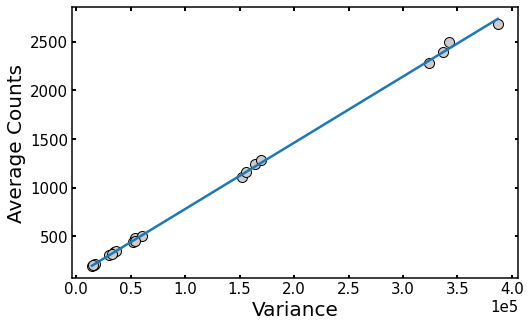

In [135]:
x = EM_300_1x1Variances
y = EM_300_1x1Averages
plt.scatter(x,y,s=100,c='0.8',edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='tab:blue');
m, b = np.polyfit(x, y, 1)
# plt.title('Andor - Conventional Gain',fontsize = title_font_size)
plt.xlabel('Variance')
plt.ylabel('Average Counts')
fig = plt.gcf();
fig.set_size_inches(plot_width, plot_height);
plt.grid(False)
ax = plt.subplot()
ax.tick_params(direction='in')
ax.tick_params(bottom=True, top=True, left=True, right=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('EM300_gain.png',dpi=1000)
print('slope = ',m)

# Photons per AD Count & per EM Count Calibration

## Discussion of Normalization Factor

Now I have the data, I need to normalize properly for the EM Gain mode. Consider that the EM Gain setting effectively multiplies each count by some number. So, since mean is defined as
$$ \bar n = \frac{\sum_{i=1}^{N}{n_i}}{N}$$
Multiplying counts by the em Gain means
$$\bar n_{\text{measured}} = \frac{\sum_{i=1}^{N}{G n_i}}{N} = G \bar n$$ 
However, for the variance, since the variance is defined as
$$ \sigma_n^2 = \frac{\sum_{i=1}^N{(n_i-\bar n)^2}}{N}$$
In addition, however, For significant EM gains, there is noise due to the EM gain process. For EMCCD cameras this corresponds to a variance of the signal of $\sqrt{2}$. See the Andor hardware guide (page 27?) for a few more details. The combined effect of this the EM Gain is
$$ \sigma_{n, \text{observed}}^2 = \frac{\sum_{i=1}^N{(\sqrt{2}(G n_i-G\times\bar n))^2}}{N} = 2G^2 \sigma_n$$


Therefore If I observe some slope
$$ s_\text{obs} = \frac{\bar n_\text{obs}}{\sigma_{n,\text{obs}}} = \frac{G\bar n}{2G^2\sigma_n} = \frac{\bar n}{2G \sigma_n} = \frac{1}{2G} s$$ 
It's off by a factor of $(2G)^{-1}$.

This slope gives me photons per AD Counts (modifying for the EM Gain) which is the number quoted by Andor (that's the only reason we care about taking it into account).

# Camera Calibrations 5/15/24

## Analyze Single Location

In [13]:
def analyzeSinglePicture(cal_type, firstRun, lastRun, printProgress=True):
    """
    This function is for calculating averages of pictures, finding the average pixel signal and variance
    of all pixel signals on the pictures.
    
    :return: This function returns the counts/photon

    """
    allPictures = []
    allAverages = []
    allVariances = []
    dataRepositoryPath = "/Volumes/Local_Data_Repository/2024/May/May 15/Raw Data/"
    for runInc in range(firstRun, lastRun + 1, 1):
        dataPath = dataRepositoryPath + cal_type + "/data_" + str(runInc) + ".h5"
        with h5.File(dataPath, "r") as hdf:
            andor = hdf.get('Andor')
            andor_items = list(andor.items())
            allPictures = np.array(andor.get('Pictures'))
            allPictures=allPictures[:, 225:275,275:325]
            print(np.shape(allPictures))
        allPictures = [item for sublist in list(allPictures[0]) for item in sublist];
        allAverages.append(np.mean(allPictures))
        allVariances.append(np.std(allPictures)**2)
        totalAverage = np.mean(allAverages)
        totalVariance = np.mean(allVariances)
        photonCount = totalAverage/totalVariance
    return photonCount,
    

In [14]:
analyzeSinglePicture("conv_gain",1,2)
conv_1x1PhotonPerADCount = np.mean(conv_1x1PhotonPerCounts) # average slopes
conv_1x1PhotonPerADstd = np.std(conv_1x1PhotonPerCounts)

(1000, 50, 50)
(1000, 50, 50)


('counts/photon =', 0.48425268559552276)

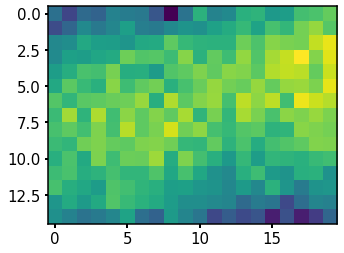

In [31]:
region = avrg_pic[215:230,355:375]
plt.imshow(region)

In [15]:
def line(x, a, b):
    return a * x + b

def analyzeSingleLocation(cal_type, firstRun, lastRun, location, printStatus=False, plot=False):
    """
    Analyzes a single location, averaging over many pictures.
    The function assumes that there is a data file for all runs in between firstrun and lastrun.
    
    :return: The function returns the fit object (i.e. an array of [a, b] for the linear fit y = a x + b) 
    and the covariance of said fit.
    """
    allAverages = []
    allVariances = []
    # dataRepositoryPath = "\\\\REGALB232EXP\\Local_Data_Repository\\2021\\andor_cal\\"
    dataRepositoryPath = "/Volumes/Local_Data_Repository/2024/May/May 15/Raw Data/"
    for runInc in range(firstRun, lastRun + 1, 1):
        allPoints = []
        dataPath = dataRepositoryPath + cal_type + "/data_" + str(runInc) + ".h5"
        with h5.File(dataPath, "r") as hdf:
            andor = hdf.get('Andor')
            andor_items = list(andor.items())
            dataFile = np.array(andor.get('Pictures')) 
            dataFile=dataFile[:, 300:350,300:350]

        for repInc in range(0, 100):
            allPoints.append(dataFile[repInc][location[0]][location[1]]) 
            # print(allPoints)
        allAverages.append(np.mean(allPoints))
        allVariances.append(np.std(allPoints)**2)
        
    param, cov = curve_fit(line, allVariances, allAverages, [1, 0]) 
    return param, cov, param[0], allAverages, allVariances; 

### Load Conventional Gain Data

In [ ]:
# initialize some arrays
conv_1x1Fits = []
conv_1x1Covs = []
conv_1x1PhotonPerCounts = []
conv_1x1Averages = []
conv_1x1Variances = []

# average over the four corners.
for location in [[0, 0]]:
#     print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("conv_gain", 1, 2, location)
    conv_1x1Fits = np.append(conv_1x1Fits, fit)
    conv_1x1Covs = np.append(conv_1x1Covs, cov)
    conv_1x1PhotonPerCounts = np.append(conv_1x1PhotonPerCounts, fit1) # generate list of slopes for each pixel as defined in location
    conv_1x1Averages = np.append(conv_1x1Averages, averages)
    conv_1x1Variances = np.append(conv_1x1Variances, variances)

In [34]:
conv_1x1PhotonPerADCount = np.mean(conv_1x1PhotonPerCounts) # average slopes
conv_1x1PhotonPerADstd = np.std(conv_1x1PhotonPerCounts)
print('counts/photon =', conv_1x1PhotonPerADCount)
print('std dev =', conv_1x1PhotonPerADstd)

counts/photon = 0.6538294587957195
std dev = 0.7616736590976956


r_value = 0.7378625195541116
slope =  0.15037047827805425


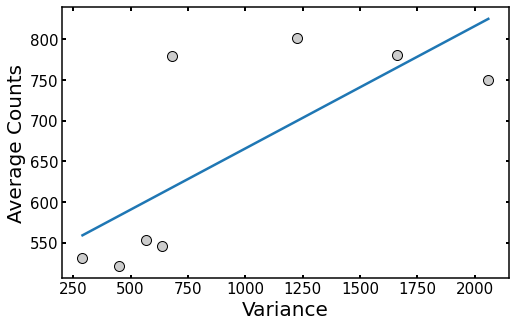

In [35]:
x = conv_1x1Variances
y = conv_1x1Averages
plt.scatter(x,y,s=100,c='0.8',edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='tab:blue');
m, b = np.polyfit(x, y, 1)
# plt.title('Andor - Conventional Gain',fontsize = title_font_size)
plt.xlabel('Variance')
plt.ylabel('Average Counts')
fig = plt.gcf();
fig.set_size_inches(plot_width, plot_height);
plt.grid(False)
ax = plt.subplot()
ax.tick_params(direction='in')
ax.tick_params(bottom=True, top=True, left=True, right=True)


# plt.savefig('conv_gain.png',dpi=1000)
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print('r_value =',r_value)
print('slope = ',slope)

In [70]:
# initialize some arrays
EM_100_1x1Fits = []
EM_100_1x1Covs = []
EM_100_1x1PhotonPerCounts = []
EM_100_1x1Averages = []
EM_100_1x1Variances = []

# average over the four corners.
for location in [[0, 0],[-1, 0], [0, -1], [-1, -1]]:
#     print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("EM_100", 6, 9, location, True)
    EM_100_1x1Fits = np.append(EM_100_1x1Fits, fit)
    EM_100_1x1Covs = np.append(EM_100_1x1Covs, cov)
    EM_100_1x1PhotonPerCounts = np.append(EM_100_1x1PhotonPerCounts, fit1) # generate list of slopes for each pixel as defined in location
    EM_100_1x1Averages = np.append(EM_100_1x1Averages, averages)
    EM_100_1x1Variances = np.append(EM_100_1x1Variances, variances)

RuntimeError: Can't decrement id ref count (unable to close file, errno = 60, error message = 'Operation timed out')

In [120]:
EM_100_1x1PhotonPerADCount = np.mean(EM_100_1x1PhotonPerCounts)*2 # average slopes
EM_100_1x1PhotonPerADstd = np.std(EM_100_1x1PhotonPerCounts)*2
EM_100_1x1PhotonPerADCount_scaled = np.mean(EM_100_1x1PhotonPerCounts)*2*100 
print('counts/photon =', EM_100_1x1PhotonPerADCount)
print('std dev =', EM_100_1x1PhotonPerADstd*2)
print('counts/photon scaled =', EM_100_1x1PhotonPerADCount_scaled)

counts/photon = 0.04064535581518338
std dev = 0.003826935144717846
counts/photon scaled = 4.064535581518338


C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_1856/2166503226.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


slope =  0.020154439195143807


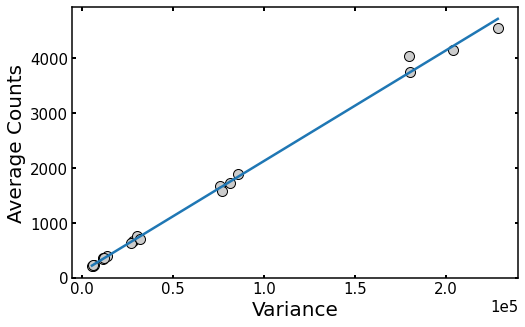

In [133]:
x = EM_100_1x1Variances
y = EM_100_1x1Averages
plt.scatter(x,y,s=100,c='0.8',edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='tab:blue');
m, b = np.polyfit(x, y, 1)
# plt.title('Andor - Conventional Gain',fontsize = title_font_size)
plt.xlabel('Variance')
plt.ylabel('Average Counts')
fig = plt.gcf();
fig.set_size_inches(plot_width, plot_height);
plt.grid(False)
ax = plt.subplot()
ax.tick_params(direction='in')
ax.tick_params(bottom=True, top=True, left=True, right=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.savefig('EM100_gain.png',dpi=1000)
print('slope = ',m)

In [44]:
# initialize some arrays
EM_300_1x1Fits = []
EM_300_1x1Covs = []
EM_300_1x1PhotonPerCounts = []
EM_300_1x1Averages = []
EM_300_1x1Variances = []

# average over the four corners.
for location in [[0, 0],[-1, 0], [0, -1], [-1, -1]]:
#     print(location)
    fit, cov, fit1, averages, variances = analyzeSingleLocation("EM_300", 9, 13, location, True)
    EM_300_1x1Fits = np.append(EM_300_1x1Fits, fit)
    EM_300_1x1Covs = np.append(EM_300_1x1Covs, cov)
    EM_300_1x1PhotonPerCounts = np.append(EM_300_1x1PhotonPerCounts, fit1) # generate list of slopes for each pixel as defined in location
    EM_300_1x1Averages = np.append(EM_300_1x1Averages, averages)
    EM_300_1x1Variances = np.append(EM_300_1x1Variances, variances)

In [137]:
EM_300_1x1PhotonPerADCount = np.mean(EM_300_1x1PhotonPerCounts)*2 # average slopes
EM_300_1x1PhotonPerADstd = np.std(EM_300_1x1PhotonPerCounts)*2
EM_300_1x1PhotonPerADCount_scaled = np.mean(EM_300_1x1PhotonPerCounts)*2*300
print('counts/photon =', EM_300_1x1PhotonPerADCount)
print('std dev =', EM_300_1x1PhotonPerADstd)
print('counts/photon Scaled =', EM_300_1x1PhotonPerADCount_scaled)

counts/photon = 0.013629068269407966
std dev = 0.0002638596372574341
counts/photon Scaled = 4.088720480822389


C:\Users\REGALL~1\AppData\Local\Temp/ipykernel_1856/2716981000.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot()


slope =  0.006808344261676491


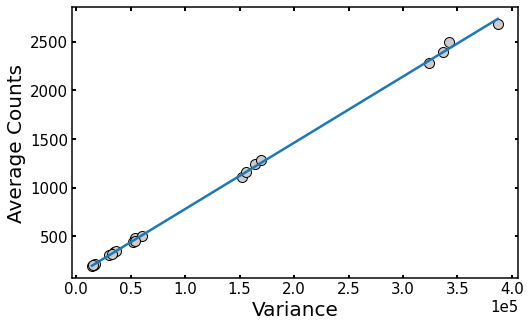

In [135]:
x = EM_300_1x1Variances
y = EM_300_1x1Averages
plt.scatter(x,y,s=100,c='0.8',edgecolors='k')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),color='tab:blue');
m, b = np.polyfit(x, y, 1)
# plt.title('Andor - Conventional Gain',fontsize = title_font_size)
plt.xlabel('Variance')
plt.ylabel('Average Counts')
fig = plt.gcf();
fig.set_size_inches(plot_width, plot_height);
plt.grid(False)
ax = plt.subplot()
ax.tick_params(direction='in')
ax.tick_params(bottom=True, top=True, left=True, right=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.savefig('EM300_gain.png',dpi=1000)
print('slope = ',m)